In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar, os, io, base64
import statsmodels.api as sm
import datetime
from dateutil import relativedelta
import matplotlib 
import pandas_datareader as dt
import io, base64, os, json, re , math
import warnings
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

In [16]:
history_cli=None
cli_df=None
history_cli=None
upcoming_forecast_cli=None
cli_df_full=None
model_cli=None

def Startup():
    
    global history_cli,cli_df,upcoming_forecast_cli,cli_df_full,model_cli
    
    #load the cli data
    cli_raw=pd.read_csv('https://stats.oecd.org/sdmx-json/data/DP_LIVE/OECD.CLI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
    cli_df=cli_raw[cli_raw['LOCATION'] =='OECD']

    full_date_list=[]
    for tm in cli_df['TIME']:
        year=int(tm.split('-')[0])
        month=int(tm.split('-')[1])
        #print calendar full date
        full_date_list.append(tm + '-'+str(calendar.monthrange(year,month)[1]))

    cli_df['Date'] = full_date_list
    cli_df['Date']= pd.to_datetime(cli_df['Date'])
    cli_df=cli_df[['Date','Value']]
    cli_df.index=cli_df['Date']

    cli_df_full=cli_df[['Date','Value']]
    cli_df_full = cli_df_full.set_index('Date')

    #Added learning columns

    prediction_months=12

    #Make a prediction column by shifting the values up by 12 months
    cli_df['Prediction']=cli_df[['Value']].shift(-prediction_months)

    #make several rollingMA to help the model learn better
    cli_df['7_months MA']=cli_df['Value'].rolling(window=7).mean()
    cli_df['4_months MA']=cli_df['Value'].rolling(window=4).mean()
    cli_df['2_months MA']=cli_df['Value'].rolling(window=2).mean()



    #drop the NaN values
    cli_cleaned=cli_df.dropna(subset=['7_months MA','4_months MA','2_months MA', 'Prediction'])

    #Get rid of the NAN values
    cli_cleaned.reset_index(drop=True, inplace=True)
    del cli_cleaned['Date']

    #Get the all the neccessary column values
    values=cli_cleaned[['Value','7_months MA','4_months MA','2_months MA','Prediction']]

    #change values to log form
    values=np.log(values)

    #change format to numpy array
    values=values.to_numpy()


    X=values[:,0:4]
    y=values[:,4:5]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    model_cli=Sequential()
    model_cli.add(Dense(200, input_dim=X.shape[1], activation='relu'))
    model_cli.add(Dense(200, activation='relu'))
    model_cli.add(Dense(1))

    model_cli.compile(loss='mean_squared_error', optimizer='adam')
    monitor=EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=0)

    model_cli.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)
    
    history_cli=model_cli.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)

    #Forecast the next dates
    cli_df_full2=cli_df_full.copy()

    #make several rollingMA to help the model learn better
    cli_df_full2['7_months MA']=cli_df_full2['Value'].rolling(window=7).mean()
    cli_df_full2['4_months MA']=cli_df_full2['Value'].rolling(window=4).mean()
    cli_df_full2['2_months MA']=cli_df_full2['Value'].rolling(window=2).mean()

    #drop the NaN values in all columns
    cli_df_full2=cli_df_full2.dropna(subset=['7_months MA','4_months MA','2_months MA'])

    #Reset the index column and delete the date columns
    cli_df_full2.reset_index(drop=True, inplace=True)
    #del cci_df_full2['Date']

    #change values to log form
    cli_df_full2=np.log(cli_df_full2)
    #change format to numpy array
    cli_df_full2=cli_df_full2.to_numpy()
    #Get only the last 12 months datapoints
    cli_df_full2=cli_df_full2[-12:]

    upcoming_forecast_cli= model_cli.predict(cli_df_full2)
    
    
    
def GetForecast(months_out3):
    
    forwarded_dates=[]
    year=2020
    for i in range(5,13):
        forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
    year=2021
    for i in range(1,5):
        forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
        
        
    #append forecasted dates to dataframe
    df_forecast=pd.DataFrame(forwarded_dates)
    df_forecast.columns=['Date']
    
    
    upcoming_f=np.exp(upcoming_forecast_cli)
    upcoming_f=pd.DataFrame(upcoming_f)

    df_forecast['Value']=upcoming_f
    #set column as datetime
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
    #set index as date
    df_forecast = df_forecast.set_index('Date')
    
    last_date=cli_df_full.tail(1)
    df_forecast=df_forecast.append(last_date)
    df_forecast=df_forecast.drop_duplicates()
    df_forecast = df_forecast.sort_index()
    
    fig,ax=plt.subplots(figsize=(16,10))
    plt.plot(df_forecast.head(months_out3+1), label='Neural Net model')
    plt.plot(cli_df_full, label='Actual')
    
    ax.axhline(y=100,color='gray')
    plt.legend(loc='best')
    plt.title('CLI Forecast Util ')
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 0.5))
    plt.grid()

    plt.show()


In [17]:
Startup()

Train on 461 samples, validate on 228 samples
Epoch 1/250
461/461 [==============================] - 1s 1ms/sample - loss: 1.9357 - val_loss: 0.0116
Epoch 2/250
461/461 [==============================] - 0s 119us/sample - loss: 0.2009 - val_loss: 0.0973
Epoch 3/250
461/461 [==============================] - 0s 128us/sample - loss: 0.0578 - val_loss: 0.0349
Epoch 4/250
461/461 [==============================] - 0s 117us/sample - loss: 0.0106 - val_loss: 2.3185e-04
Epoch 5/250
461/461 [==============================] - 0s 130us/sample - loss: 0.0022 - val_loss: 0.0019
Epoch 6/250
461/461 [==============================] - 0s 117us/sample - loss: 7.8810e-04 - val_loss: 2.5967e-04
Epoch 7/250
461/461 [==============================] - 0s 178us/sample - loss: 3.2832e-04 - val_loss: 2.6031e-04
Epoch 8/250
461/461 [==============================] - 0s 134us/sample - loss: 2.5350e-04 - val_loss: 2.4659e-04
Epoch 9/250
461/461 [==============================] - 0s 117us/sample - loss: 2.4790e-0

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


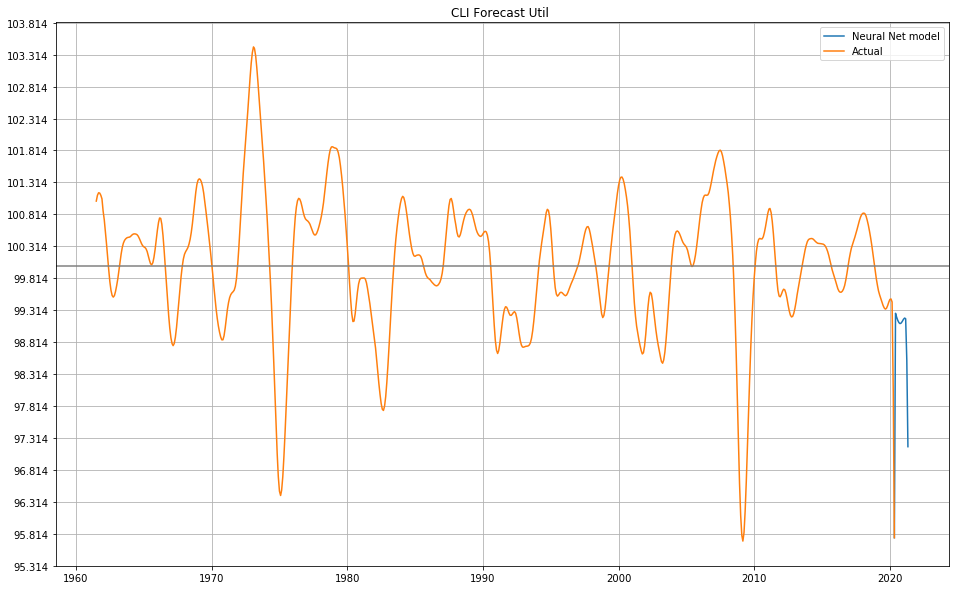

In [18]:
GetForecast(12)